# GRPO Evaluation - Modular Version

**Purpose**: Evaluate trained GRPO checkpoints with proper optimization direction handling.

**Key Features**:
- ✅ **Checkpoint-first approach** - load any checkpoint to evaluate
- ✅ **Auto-detect optimization** - reads direction from checkpoint metadata
- ✅ **Independent cells** - no need to run training first
- ✅ **Correct metrics** - handles both minimization and maximization
- ✅ **Multiple modes** - single checkpoint, compare checkpoints, compare objectives

**Workflow**:
1. Select evaluation mode and checkpoints
2. Load checkpoint(s) and validate metadata
3. Generate or load test SCMs
4. Run evaluation with baselines
5. Generate visualizations with correct labels
6. Export results for analysis

## 1. Setup and Configuration

In [1]:
#!/usr/bin/env python3
"""
Cell 1: Import base components and configure environment

This cell sets up the evaluation environment.
"""

import sys
import os
from pathlib import Path
import logging
import json
import time
import subprocess
import shutil
from datetime import datetime
from typing import Dict, List, Any, Optional, Tuple
from dataclasses import dataclass

# Add project root to path
project_root = Path.cwd().parent if Path.cwd().name == "experiments" else Path.cwd()
sys.path.insert(0, str(project_root))

# Import base components
from scripts.notebooks.base_components import (
    NotebookError, CheckpointManager, SCMGenerator,
    OptimizationConfig, CheckpointMetadata, validate_environment,
    format_results_summary
)
from scripts.notebooks.config_templates import create_evaluation_config

# Core imports
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as random
import pyrsistent as pyr

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s][%(name)s][%(levelname)s] - %(message)s'
)
logger = logging.getLogger(__name__)

# Validate environment
try:
    env_info = validate_environment()
    print("✅ Environment Setup Complete")
    print(f"📁 Project root: {project_root}")
    print(f"🔧 JAX devices: {env_info['jax_devices']}")
    print(f"📅 Date: {env_info['timestamp']}")
except Exception as e:
    raise NotebookError(f"Environment validation failed: {e}")

# Initialize checkpoint manager
checkpoint_dir = project_root / "checkpoints" / "grpo_training"
checkpoint_manager = CheckpointManager(checkpoint_dir)
print(f"\n📁 Checkpoint directory: {checkpoint_dir}")

INFO:2025-07-25 13:54:15,653:jax._src.xla_bridge:749: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
[2025-07-25 13:54:15,653][jax._src.xla_bridge][INFO] - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


✅ Environment Setup Complete
📁 Project root: /Users/harellidar/Documents/Imperial/Individual_Project/causal_bayes_opt
🔧 JAX devices: [CpuDevice(id=0)]
📅 Date: 2025-07-25 13:54:15

📁 Checkpoint directory: /Users/harellidar/Documents/Imperial/Individual_Project/causal_bayes_opt/checkpoints/grpo_training


In [2]:
"""
Cell 2: Configure evaluation parameters

Set evaluation mode and parameters for the run.
"""

# EVALUATION MODE SELECTION
EVALUATION_MODE = "SINGLE_CHECKPOINT"  # Options: "SINGLE_CHECKPOINT", "COMPARE_CHECKPOINTS", "COMPARE_OBJECTIVES"

# Configuration for different modes
if EVALUATION_MODE == "SINGLE_CHECKPOINT":
    # Evaluate one checkpoint against baselines
    NUM_TEST_SCMS = 10
    RUNS_PER_METHOD = 3
    INTERVENTION_BUDGET = 10
    
elif EVALUATION_MODE == "COMPARE_CHECKPOINTS":
    # Compare multiple checkpoints
    COMPARISON_COUNT = 3  # Number of checkpoints to compare
    NUM_TEST_SCMS = 5  # Fewer SCMs for faster comparison
    RUNS_PER_METHOD = 2
    INTERVENTION_BUDGET = 8
    
elif EVALUATION_MODE == "COMPARE_OBJECTIVES":
    # Compare minimization vs maximization
    NUM_TEST_SCMS = 8
    RUNS_PER_METHOD = 3
    INTERVENTION_BUDGET = 10

else:
    raise NotebookError(f"Unknown evaluation mode: {EVALUATION_MODE}")

# General settings
RANDOM_SEED = 42

print("🎯 Evaluation Configuration")
print("=" * 50)
print(f"Mode: {EVALUATION_MODE}")
print(f"Test SCMs: {NUM_TEST_SCMS}")
print(f"Runs per method: {RUNS_PER_METHOD}")
print(f"Intervention budget: {INTERVENTION_BUDGET}")
print(f"Random seed: {RANDOM_SEED}")

if EVALUATION_MODE == "COMPARE_CHECKPOINTS":
    print(f"Checkpoints to compare: {COMPARISON_COUNT}")


🎯 Evaluation Configuration
Mode: SINGLE_CHECKPOINT
Test SCMs: 10
Runs per method: 3
Intervention budget: 10
Random seed: 42


## 2. Evaluation Mode and Checkpoint Selection

In [3]:
"""
Cell 4: Select checkpoints for evaluation

This cell handles checkpoint selection based on the evaluation mode.
Uses intelligent discovery instead of hardcoded names.
"""

print("📋 Intelligent Checkpoint Selection")
print("=" * 50)

# Get available checkpoints
try:
    available_checkpoints = checkpoint_manager.list_checkpoints()
    if not available_checkpoints:
        raise NotebookError("No checkpoints found")
        
    print(f"Found {len(available_checkpoints)} total checkpoints")
    
    # Show usable checkpoints by direction
    usable_minimize = checkpoint_manager.find_usable_checkpoints('MINIMIZE')
    usable_maximize = checkpoint_manager.find_usable_checkpoints('MAXIMIZE')
    
    print(f"Usable checkpoints:")
    print(f"  MINIMIZE: {len(usable_minimize)}")
    print(f"  MAXIMIZE: {len(usable_maximize)}")
    print(f"  Total usable: {len(usable_minimize) + len(usable_maximize)}")
        
except Exception as e:
    raise NotebookError(f"Failed to analyze checkpoints: {e}")

# SELECT CHECKPOINTS BASED ON MODE
selected_checkpoints = []

if EVALUATION_MODE == "SINGLE_CHECKPOINT":
    # Find best MINIMIZE checkpoint (preferred for comparison with PARENT_SCALE)
    best_checkpoint = checkpoint_manager.find_best_checkpoint({
        'optimization_direction': 'MINIMIZE',
        'training_mode': 'QUICK'
    })
    
    if best_checkpoint:
        selected_checkpoints = [best_checkpoint]
        print(f"🎯 Selected best MINIMIZE checkpoint: {best_checkpoint.name}")
        
        # Validate the selected checkpoint
        validation = checkpoint_manager.validate_checkpoint(best_checkpoint)
        if validation['is_valid']:
            print(f"  ✅ Checkpoint is valid and ready for evaluation")
        else:
            print(f"  ⚠️ Checkpoint issues: {validation['issues']}")
    else:
        # Fallback: try any usable checkpoint
        all_usable = checkpoint_manager.find_usable_checkpoints()
        if all_usable:
            selected_checkpoints = [all_usable[0]]
            print(f"🎯 No MINIMIZE checkpoint found, using: {all_usable[0].name}")
            print(f"  Optimization: {all_usable[0].optimization_config.direction}")
        else:
            raise NotebookError("No usable checkpoints found. Please ensure checkpoints have both metadata.json and checkpoint.pkl files.")

elif EVALUATION_MODE == "COMPARE_CHECKPOINTS":
    # Get multiple usable checkpoints
    all_usable = checkpoint_manager.find_usable_checkpoints()
    comparison_count = min(COMPARISON_COUNT, len(all_usable))
    selected_checkpoints = all_usable[:comparison_count]
    print(f"📊 Selected {comparison_count} checkpoints for comparison")

elif EVALUATION_MODE == "COMPARE_OBJECTIVES":
    # Get best from each optimization direction
    best_minimize = checkpoint_manager.find_best_checkpoint({'optimization_direction': 'MINIMIZE'})
    best_maximize = checkpoint_manager.find_best_checkpoint({'optimization_direction': 'MAXIMIZE'})
    
    selected_checkpoints = []
    if best_minimize:
        selected_checkpoints.append(best_minimize)
    if best_maximize:
        selected_checkpoints.append(best_maximize)
    
    if not selected_checkpoints:
        raise NotebookError("Need checkpoints from both MINIMIZE and MAXIMIZE directions for objective comparison")
    
    print(f"🔄 Selected checkpoints for objective comparison:")
    for ckpt in selected_checkpoints:
        print(f"  - {ckpt.name} ({ckpt.optimization_config.direction})")

else:
    raise NotebookError(f"Unknown evaluation mode: {EVALUATION_MODE}")

# Final validation
if not selected_checkpoints:
    raise NotebookError("No checkpoints selected for evaluation")

print(f"✅ Final Selection ({len(selected_checkpoints)} checkpoint(s)):")
for i, checkpoint in enumerate(selected_checkpoints, 1):
    print(f"{i}. {checkpoint.name}")
    print(f"     Optimization: {checkpoint.optimization_config.direction}")
    print(f"     Training mode: {checkpoint.training_config.get('mode', 'unknown')}")
    print(f"     Path: {checkpoint.path}")
    
    # Final validation
    validation = checkpoint_manager.validate_checkpoint(checkpoint)
    if validation['is_valid']:
        print(f"     Status: ✅ Ready for evaluation")
    else:
        print(f"     Status: ❌ Issues found: {validation['issues']}")
        raise NotebookError(f"Selected checkpoint {checkpoint.name} has validation issues: {validation['issues']}")

print(f"🚀 All selected checkpoints validated and ready for evaluation\!")

<>:108: SyntaxWarning: invalid escape sequence '\!'
<>:108: SyntaxWarning: invalid escape sequence '\!'
/var/folders/2f/7z7glsfj1fd22nlr6wj56z5w0000gn/T/ipykernel_16390/2931854767.py:108: SyntaxWarning: invalid escape sequence '\!'
  print(f"🚀 All selected checkpoints validated and ready for evaluation\!")
[2025-07-25 13:54:15,670][scripts.notebooks.base_components][WARNING] - Legacy checkpoint detected - inferring optimization direction
[2025-07-25 13:54:15,671][scripts.notebooks.base_components][WARNING] - Failed to load metadata from /Users/harellidar/Documents/Imperial/Individual_Project/causal_bayes_opt/checkpoints/grpo_training/grpo_quick_minimize_20250723_094650/metadata.json: Expecting value: line 11 column 15 (char 381)
[2025-07-25 13:54:15,673][scripts.notebooks.base_components][WARNING] - Legacy checkpoint detected - inferring optimization direction
[2025-07-25 13:54:15,674][scripts.notebooks.base_components][WARNING] - Legacy checkpoint detected - inferring optimization dir

📋 Intelligent Checkpoint Selection
Found 11 total checkpoints
Usable checkpoints:
  MINIMIZE: 8
  MAXIMIZE: 2
  Total usable: 10
🎯 Selected best MINIMIZE checkpoint: grpo_quick_minimize_20250725_134914
  ✅ Checkpoint is valid and ready for evaluation
✅ Final Selection (1 checkpoint(s)):
1. grpo_quick_minimize_20250725_134914
     Optimization: MINIMIZE
     Training mode: QUICK
     Path: /Users/harellidar/Documents/Imperial/Individual_Project/causal_bayes_opt/checkpoints/grpo_training/grpo_quick_minimize_20250725_134914
     Status: ✅ Ready for evaluation
🚀 All selected checkpoints validated and ready for evaluation\!


## 3. Load and Validate Checkpoints

In [4]:
"""
Cell 3: Load checkpoint metadata and validate

This cell loads the selected checkpoints and validates their metadata.
"""

print("📥 Loading Checkpoint Metadata")
print("=" * 60)

# Store loaded checkpoint info
loaded_checkpoints = {}

for ckpt in selected_checkpoints:
    print(f"\nLoading: {ckpt.name}")
    try:
        # For now, we're using the metadata we already have
        # In production, this would load the actual model parameters
        loaded_checkpoints[ckpt.name] = {
            'metadata': ckpt,
            'optimization_config': ckpt.optimization_config,
            'training_config': ckpt.training_config,
            'model_params': None  # TODO: Load actual model parameters
        }
        
        print(f"  ✓ Optimization: {ckpt.optimization_config.direction}")
        print(f"  ✓ Training mode: {ckpt.training_config.get('mode', 'unknown')}")
        print(f"  ✓ Episodes completed: {ckpt.training_results.get('episodes_completed', 'unknown')}")
        print(f"  ✓ Duration: {ckpt.training_results.get('duration_minutes', 0):.1f} minutes")
        
        # Show reward weights if available
        if 'reward_weights' in ckpt.training_config:
            weights = ckpt.training_config['reward_weights']
            print(f"  ✓ Reward weights: opt={weights.get('optimization', 0):.1f}, "
                  f"struct={weights.get('discovery', 0):.1f}, "
                  f"eff={weights.get('efficiency', 0):.1f}")
                  
    except Exception as e:
        print(f"  ✗ Failed to load: {e}")
        raise NotebookError(f"Failed to load checkpoint {ckpt.name}: {e}")

print(f"\n✅ Loaded {len(loaded_checkpoints)} checkpoint(s) successfully")

# Check optimization compatibility for comparison modes
if EVALUATION_MODE == "COMPARE_OBJECTIVES":
    directions = [ckpt.optimization_config.direction for ckpt in selected_checkpoints]
    if len(set(directions)) == 1:
        print(f"\n⚠️ Warning: All checkpoints have same optimization direction: {directions[0]}")
        print("   Objective comparison may not be meaningful.")
    else:
        print(f"\n✅ Comparing optimization directions: {set(directions)}")

📥 Loading Checkpoint Metadata

Loading: grpo_quick_minimize_20250725_134914
  ✓ Optimization: MINIMIZE
  ✓ Training mode: QUICK
  ✓ Episodes completed: 96
  ✓ Duration: 5.2 minutes
  ✓ Reward weights: opt=0.8, struct=0.1, eff=0.1

✅ Loaded 1 checkpoint(s) successfully


## 4. Generate Test SCMs

In [5]:
"""
Cell 4: Generate test SCMs for evaluation

Create a balanced set of test SCMs different from training.
"""

print("🔬 Generating Test SCMs")
print("=" * 60)

# Initialize SCM generator
scm_generator = SCMGenerator()

# Generate test SCMs with different seed than training
test_seed = RANDOM_SEED + 1000  # Ensure different from training

try:
    test_scms, test_metadata = scm_generator.generate_balanced_scms(
        num_scms=NUM_TEST_SCMS,
        variable_range=(3, 6),
        structure_types=['fork', 'chain', 'collider', 'mixed'],
        seed=test_seed
    )
    
    print(f"\n✅ Generated {len(test_scms)} test SCMs")
    
    # Analyze distribution
    distribution = scm_generator._summarize_distribution(test_metadata)
    print(f"\n📊 Test Set Distribution:")
    print(f"  Structure types: {distribution['structure_types']}")
    print(f"  Variable counts: {distribution['variable_counts']}")
    
    # Save test SCM metadata
    test_scm_path = project_root / "results" / "test_scms" / f"test_scms_{test_seed}.json"
    test_scm_path.parent.mkdir(parents=True, exist_ok=True)
    
    with open(test_scm_path, 'w') as f:
        json.dump({
            'metadata': test_metadata,
            'config': {
                'num_scms': len(test_scms),
                'seed': test_seed,
                'variable_range': [3, 6],
                'structure_types': ['fork', 'chain', 'collider', 'mixed']
            },
            'generated_at': datetime.now().isoformat()
        }, f, indent=2)
    
    print(f"\n💾 Saved test SCM metadata to: {test_scm_path}")
    
except Exception as e:
    raise NotebookError(f"Failed to generate test SCMs: {e}")

🔬 Generating Test SCMs


[2025-07-25 13:54:16,116][causal_bayes_opt.experiments.test_scms][INFO] - Created linear SCM with 3 variables, 2 edges, target='X1'
[2025-07-25 13:54:16,116][causal_bayes_opt.experiments.variable_scm_factory][INFO] - Generated fork SCM: 3 vars, 2 edges, target=X1
[2025-07-25 13:54:16,130][causal_bayes_opt.experiments.test_scms][INFO] - Created linear SCM with 4 variables, 3 edges, target='X2'
[2025-07-25 13:54:16,131][causal_bayes_opt.experiments.variable_scm_factory][INFO] - Generated fork SCM: 4 vars, 3 edges, target=X2
[2025-07-25 13:54:16,145][causal_bayes_opt.experiments.test_scms][INFO] - Created linear SCM with 5 variables, 4 edges, target='X2'
[2025-07-25 13:54:16,146][causal_bayes_opt.experiments.variable_scm_factory][INFO] - Generated fork SCM: 5 vars, 4 edges, target=X2
[2025-07-25 13:54:16,148][causal_bayes_opt.experiments.test_scms][INFO] - Created linear SCM with 6 variables, 5 edges, target='X3'
[2025-07-25 13:54:16,148][causal_bayes_opt.experiments.variable_scm_factory]


✅ Generated 10 test SCMs

📊 Test Set Distribution:
  Structure types: {'fork': 4, 'chain': 4, 'collider': 2}
  Variable counts: {3: 3, 4: 3, 5: 2, 6: 2}

💾 Saved test SCM metadata to: /Users/harellidar/Documents/Imperial/Individual_Project/causal_bayes_opt/results/test_scms/test_scms_1042.json


## 5. Run Evaluation

In [6]:
"""
Cell 5: Run evaluation with proper optimization handling

Evaluate checkpoints against baselines with correct metrics.
"""

print("🏁 Running Evaluation")
print("=" * 60)

# Create output directory
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = project_root / "results" / f"evaluation_{EVALUATION_MODE.lower()}_{timestamp}"
output_dir.mkdir(parents=True, exist_ok=True)

print(f"📁 Output directory: {output_dir}")
print(f"\nEvaluation parameters:")
print(f"  Mode: {EVALUATION_MODE}")
print(f"  Test SCMs: {NUM_TEST_SCMS}")
print(f"  Runs per method: {RUNS_PER_METHOD}")
print(f"  Intervention budget: {INTERVENTION_BUDGET}")

# Store results
evaluation_results = {}
evaluation_start_time = time.time()

# Import the unified evaluation function
from src.causal_bayes_opt.evaluation import run_evaluation

# Run evaluation for each checkpoint
for ckpt in selected_checkpoints:
    print(f"\n{'='*60}")
    print(f"Evaluating: {ckpt.name}")
    print(f"Optimization: {ckpt.optimization_config.direction}")
    
    # Create checkpoint-specific output directory
    ckpt_output_dir = output_dir / ckpt.name
    ckpt_output_dir.mkdir(exist_ok=True)
    
    # Prepare evaluation config
    eval_config = {
        'n_scms': NUM_TEST_SCMS,
        'n_seeds': RUNS_PER_METHOD,  # This is the correct parameter name
        'parallel': False,  # Disable parallel to avoid serialization issues
        'experiment': {
            'runs_per_method': RUNS_PER_METHOD,
            'target': {
                'max_interventions': INTERVENTION_BUDGET,
                'n_observational_samples': 100,
                'optimization_direction': ckpt.optimization_config.direction
            },
            'scm_generation': {
                'use_variable_factory': True,
                'variable_range': [3, 6],
                'structure_types': ['fork', 'chain', 'collider', 'mixed']
            }
        },
        'visualization': {
            'enabled': True,
            'plot_types': ['target_trajectory', 'f1_trajectory', 'shd_trajectory', 'method_comparison']
        }
    }
    
    # Run evaluation using the unified system
    print(f"\nRunning evaluation with unified system...")
    start_time = time.time()
    
    try:
        # Use our test SCMs if already generated
        comparison_results = run_evaluation(
            checkpoint_path=ckpt.path,
            output_dir=ckpt_output_dir,
            config=eval_config,
            test_scms=test_scms if 'test_scms' in locals() else None,
            methods=['grpo', 'random', 'learning', 'oracle']  # Compare against all baselines
        )
        
        duration = (time.time() - start_time) / 60
        print(f"\n✅ Evaluation completed in {duration:.1f} minutes")
        
        # Store results
        evaluation_results[ckpt.name] = {
            'results': comparison_results,
            'optimization_direction': ckpt.optimization_config.direction,
            'checkpoint_metadata': ckpt.to_dict(),
            'duration_minutes': duration
        }
        
        # Quick summary - FIXED: use method_metrics instead of method_results
        print("\n📊 Quick Summary:")
        for method_name, metrics in comparison_results.method_metrics.items():
            improvement = metrics.mean_improvement
            # Format based on optimization direction
            if ckpt.optimization_config.is_minimizing:
                display_val = f"{-improvement:.4f} (lower is better)"
            else:
                display_val = f"{improvement:.4f} (higher is better)"
            print(f"  {method_name}: {display_val}")
            
    except Exception as e:
        print(f"\n❌ Evaluation failed: {e}")
        import traceback
        traceback.print_exc()
        evaluation_results[ckpt.name] = {'error': str(e)}

total_duration = (time.time() - evaluation_start_time) / 60

print(f"\n{'='*60}")
print(f"✅ All evaluations complete!")
print(f"  Total duration: {total_duration:.1f} minutes")
print(f"  Successful: {sum(1 for r in evaluation_results.values() if 'error' not in r)}/{len(evaluation_results)}")
print(f"\n📁 Results saved to: {output_dir}")

[2025-07-25 13:54:16,288][src.causal_bayes_opt.evaluation.run_evaluation][INFO] - Output directory: /Users/harellidar/Documents/Imperial/Individual_Project/causal_bayes_opt/results/evaluation_single_checkpoint_20250725_135416/grpo_quick_minimize_20250725_134914
[2025-07-25 13:54:16,288][src.causal_bayes_opt.evaluation.run_evaluation][INFO] - Running evaluation with methods: ['grpo', 'random', 'learning', 'oracle']
[2025-07-25 13:54:16,290][src.causal_bayes_opt.evaluation.unified_runner][INFO] - Registered method: Random_Baseline
[2025-07-25 13:54:16,290][src.causal_bayes_opt.evaluation.run_evaluation][INFO] - Registered random evaluator
[2025-07-25 13:54:16,291][src.causal_bayes_opt.evaluation.unified_runner][INFO] - Registered method: Learning_Baseline
[2025-07-25 13:54:16,292][src.causal_bayes_opt.evaluation.run_evaluation][INFO] - Registered learning evaluator
[2025-07-25 13:54:16,292][src.causal_bayes_opt.evaluation.unified_runner][INFO] - Registered method: Oracle_Baseline
[2025-0

🏁 Running Evaluation
📁 Output directory: /Users/harellidar/Documents/Imperial/Individual_Project/causal_bayes_opt/results/evaluation_single_checkpoint_20250725_135416

Evaluation parameters:
  Mode: SINGLE_CHECKPOINT
  Test SCMs: 10
  Runs per method: 3
  Intervention budget: 10

Evaluating: grpo_quick_minimize_20250725_134914
Optimization: MINIMIZE

Running evaluation with unified system...


[2025-07-25 13:54:16,657][src.causal_bayes_opt.interventions.handlers][INFO] - Applied perfect intervention on ['X0']
[2025-07-25 13:54:16,683][src.causal_bayes_opt.interventions.handlers][INFO] - Applied perfect intervention on ['X0']
[2025-07-25 13:54:16,708][src.causal_bayes_opt.interventions.handlers][INFO] - Applied perfect intervention on ['X2']
[2025-07-25 13:54:16,731][src.causal_bayes_opt.interventions.handlers][INFO] - Applied perfect intervention on ['X0']
[2025-07-25 13:54:16,755][src.causal_bayes_opt.interventions.handlers][INFO] - Applied perfect intervention on ['X2']
[2025-07-25 13:54:16,778][src.causal_bayes_opt.interventions.handlers][INFO] - Applied perfect intervention on ['X0']
[2025-07-25 13:54:16,803][src.causal_bayes_opt.interventions.handlers][INFO] - Applied perfect intervention on ['X0']
[2025-07-25 13:54:16,830][src.causal_bayes_opt.interventions.handlers][INFO] - Applied perfect intervention on ['X0']
[2025-07-25 13:54:16,857][src.causal_bayes_opt.intervent


✅ Evaluation completed in 8.6 minutes

📊 Quick Summary:
  Random_Baseline: -0.0602 (lower is better)
  Learning_Baseline: 0.0862 (lower is better)
  Oracle_Baseline: 2.3760 (lower is better)
  GRPO_grpo_quick_minimize_20250725_134914: -0.0000 (lower is better)

✅ All evaluations complete!
  Total duration: 8.6 minutes
  Successful: 1/1

📁 Results saved to: /Users/harellidar/Documents/Imperial/Individual_Project/causal_bayes_opt/results/evaluation_single_checkpoint_20250725_135416


## 6. Generate Visualizations

📊 Generating Visualizations

📈 Visualizations for: grpo_quick_minimize_20250725_134914
Found 1 plots:
  - trajectory_comparison.png


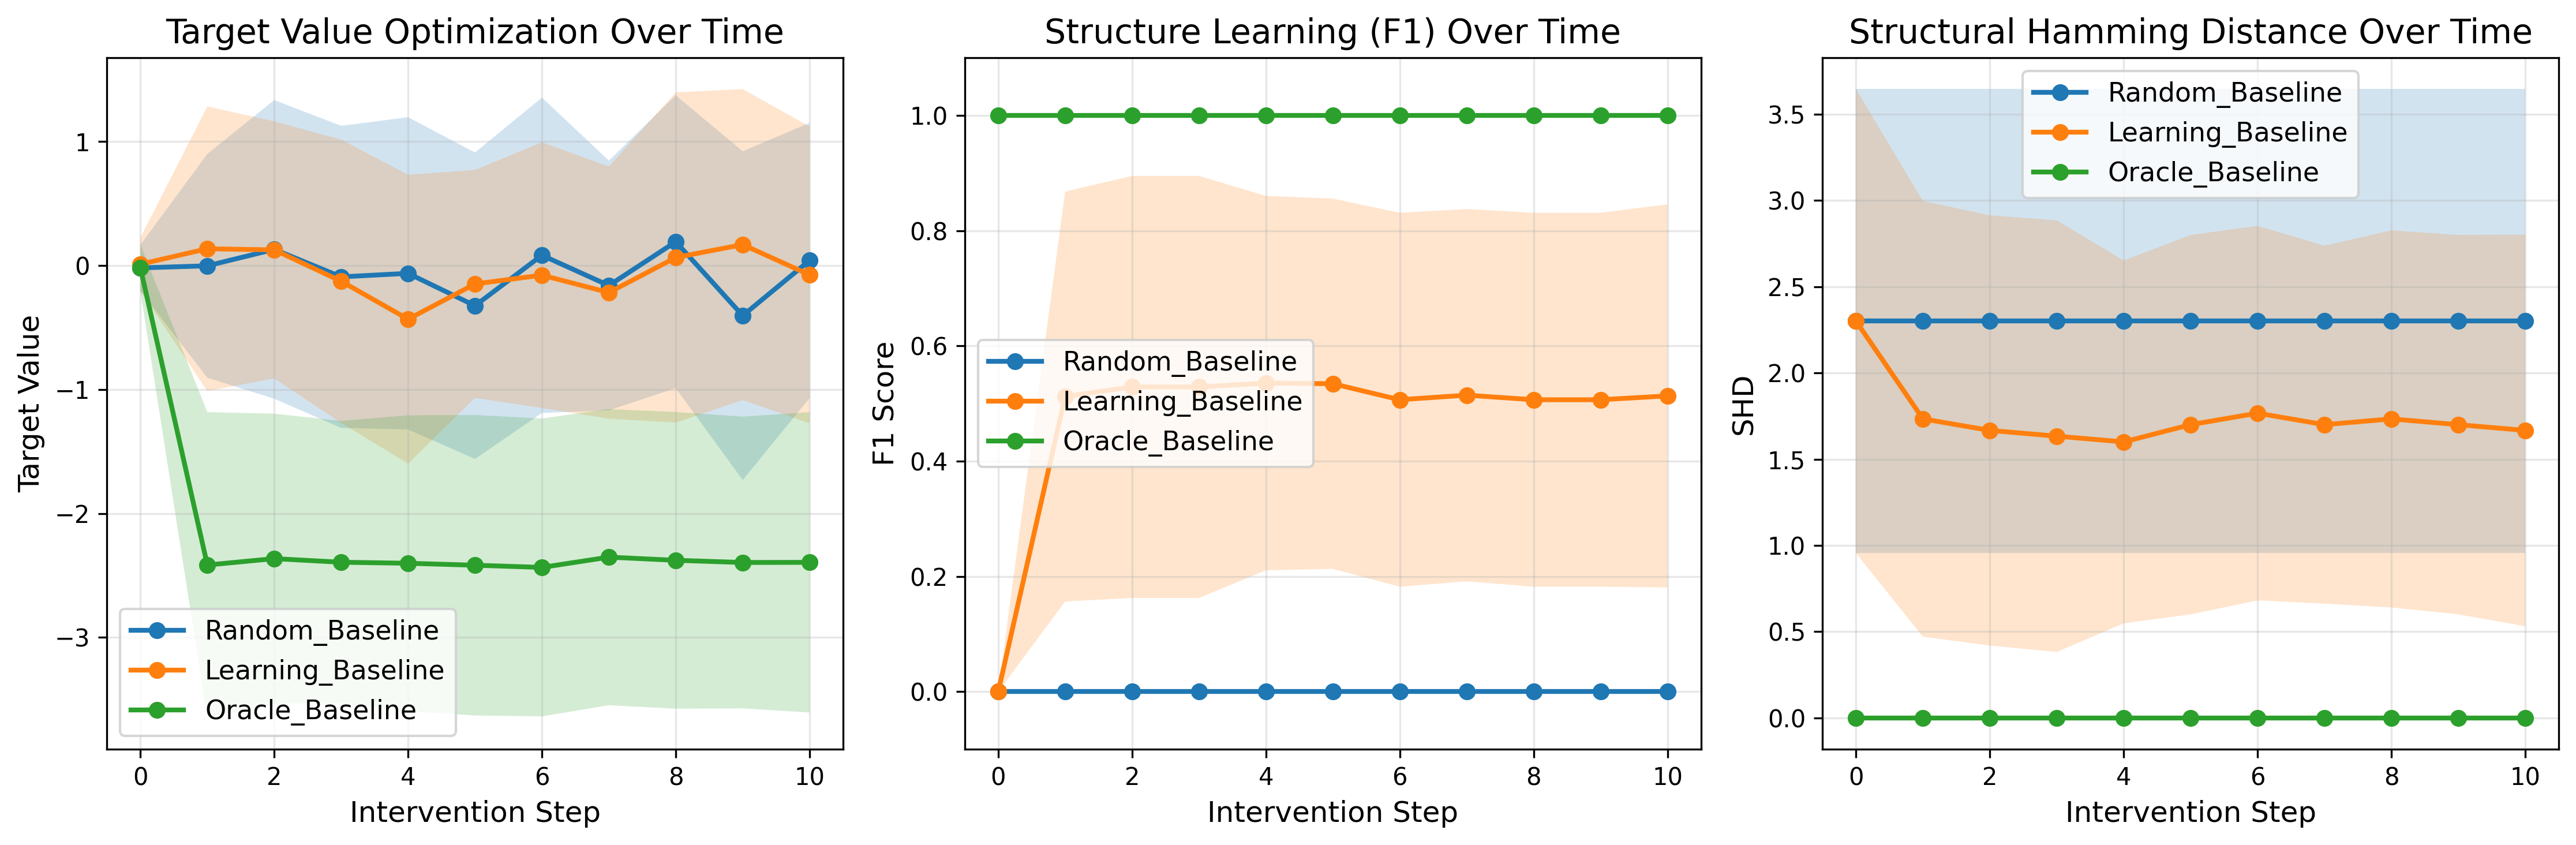


📊 Performance Summary for grpo_quick_minimize_20250725_134914:
--------------------------------------------------------------------------------
Method                             Improvement     Final Value    Success Rate
--------------------------------------------------------------------------------
Random_Baseline                        -0.0602 ↓          0.0420         100.0%
Learning_Baseline                       0.0862 ↓         -0.0747         100.0%
Oracle_Baseline                         2.3760 ↓         -2.3942         100.0%
GRPO_grpo_quick_minimize_20250725_134914         -0.0000 ↓          0.0000           0.0%
--------------------------------------------------------------------------------

✅ Visualization complete!
📁 All plots saved to: /Users/harellidar/Documents/Imperial/Individual_Project/causal_bayes_opt/results/evaluation_single_checkpoint_20250725_135416


In [7]:
"""
Cell 6: Generate visualizations with trajectory plots

Create comprehensive plots showing method performance over time.
"""

print("📊 Generating Visualizations")
print("=" * 60)

# Check if we have results to visualize
valid_results = {k: v for k, v in evaluation_results.items() if 'error' not in v}

if not valid_results:
    print("❌ No valid results to visualize")
else:
    # Process results for each checkpoint
    for ckpt_name, eval_data in valid_results.items():
        print(f"\n📈 Visualizations for: {ckpt_name}")
        
        comparison_results = eval_data['results']
        opt_direction = eval_data['optimization_direction']
        
        # The plots should already be generated by run_evaluation
        # Let's check what was created
        ckpt_output_dir = output_dir / ckpt_name
        plot_files = list(ckpt_output_dir.glob("*.png"))
        plot_files.extend(list((ckpt_output_dir / "plots").glob("*.png")))
        
        if plot_files:
            print(f"Found {len(plot_files)} plots:")
            for plot_file in plot_files:
                print(f"  - {plot_file.name}")
                # Display the plot
                try:
                    display(Image(filename=str(plot_file)))
                except:
                    print(f"    (Could not display {plot_file.name})")
        
        # Also create a summary table - FIXED: use method_metrics instead of method_results
        print(f"\n📊 Performance Summary for {ckpt_name}:")
        print("-" * 80)
        print(f"{'Method':<30} {'Improvement':>15} {'Final Value':>15} {'Success Rate':>15}")
        print("-" * 80)
        
        for method_name, metrics in comparison_results.method_metrics.items():
            improvement = metrics.mean_improvement
            final_value = metrics.mean_final_value
            success_rate = metrics.success_rate if hasattr(metrics, 'success_rate') else metrics.n_successful / metrics.n_runs if metrics.n_runs > 0 else 0.0
            
            if opt_direction == "MINIMIZE":
                # For minimization, negative improvement is good
                improvement_str = f"{-improvement:>15.4f} ↓"
            else:
                improvement_str = f"{improvement:>15.4f} ↑"
            
            print(f"{method_name:<30} {improvement_str} {final_value:>15.4f} {success_rate:>14.1%}")
        
        print("-" * 80)
        
        # Statistical significance - check if it exists
        if hasattr(comparison_results, 'statistical_tests') and comparison_results.statistical_tests:
            print("\n🔍 Statistical Significance:")
            for test_name, test_result in comparison_results.statistical_tests.items():
                if isinstance(test_result, dict):
                    p_value = test_result.get('p_value', 1.0)
                    significant = p_value < 0.05
                    print(f"  {test_name}: p={p_value:.4f} {'✅' if significant else '❌'}")
    
    print(f"\n✅ Visualization complete!")
    print(f"📁 All plots saved to: {output_dir}")

## 7. Export Results and Summary

In [8]:
"""
Cell 7: Export results and generate summary report

Save all results and provide clear guidance on where to find outputs.
"""

print("💾 Exporting Results")
print("=" * 60)

# Prepare export data - convert ComparisonResults to dict
export_results = {}
for ckpt_name, result_data in evaluation_results.items():
    if 'error' in result_data:
        export_results[ckpt_name] = result_data
    else:
        # Convert ComparisonResults to dict
        export_results[ckpt_name] = {
            'results': result_data['results'].to_dict(),  # Convert to dict!
            'optimization_direction': result_data['optimization_direction'],
            'checkpoint_metadata': result_data['checkpoint_metadata'],
            'duration_minutes': result_data['duration_minutes']
        }

export_data = {
    'evaluation_config': {
        'mode': EVALUATION_MODE,
        'num_test_scms': NUM_TEST_SCMS,
        'runs_per_method': RUNS_PER_METHOD,
        'intervention_budget': INTERVENTION_BUDGET,
        'random_seed': RANDOM_SEED,
        'timestamp': timestamp
    },
    'checkpoints_evaluated': [
        {
            'name': ckpt.name,
            'optimization_direction': ckpt.optimization_config.direction,
            'path': str(ckpt.path),
            'training_mode': ckpt.training_config.get('mode', 'unknown')
        }
        for ckpt in selected_checkpoints
    ],
    'results': export_results,  # Use the converted results
    'method_performance': method_performance if 'method_performance' in locals() else {},
    'duration_minutes': total_duration if 'total_duration' in locals() else 0
}

# Save JSON results
json_path = output_dir / "evaluation_results.json"

with open(json_path, 'w') as f:
    json.dump(export_data, f, indent=2)

print(f"✅ Results saved to: {json_path}")

# Generate text summary
summary_path = output_dir / "evaluation_summary.txt"
with open(summary_path, 'w') as f:
    f.write(f"GRPO Evaluation Summary\n")
    f.write(f"="*60 + "\n\n")
    
    f.write(f"Evaluation Mode: {EVALUATION_MODE}\n")
    f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}\n")
    f.write(f"Duration: {total_duration:.1f} minutes\n\n" if 'total_duration' in locals() else "\n")
    
    f.write(f"Configuration:\n")
    f.write(f"  Test SCMs: {NUM_TEST_SCMS}\n")
    f.write(f"  Runs per method: {RUNS_PER_METHOD}\n")
    f.write(f"  Intervention budget: {INTERVENTION_BUDGET}\n")
    f.write(f"  Random seed: {RANDOM_SEED}\n\n")
    
    f.write(f"Checkpoints Evaluated:\n")
    for ckpt in selected_checkpoints:
        f.write(f"  - {ckpt.name} ({ckpt.optimization_config.direction})\n")
    
    f.write(f"\nKey Findings:\n")
    f.write("-" * 60 + "\n")
    
    # Summarize results
    if 'method_performance' in locals() and method_performance:
        # Group by checkpoint
        for ckpt in selected_checkpoints:
            f.write(f"\n{ckpt.name} ({ckpt.optimization_config.direction}):\n")
            
            # Get methods for this checkpoint
            ckpt_methods = {k: v for k, v in method_performance.items() if v['checkpoint'] == ckpt.name}
            
            if ckpt_methods:
                # Sort by performance
                if ckpt.optimization_config.is_minimizing:
                    sorted_methods = sorted(ckpt_methods.items(), key=lambda x: x[1]['actual_value'])
                else:
                    sorted_methods = sorted(ckpt_methods.items(), key=lambda x: x[1]['actual_value'], reverse=True)
                
                for rank, (key, perf) in enumerate(sorted_methods[:5], 1):  # Top 5
                    marker = "*" if 'Policy' in perf['method'] or 'Trained' in perf['method'] else " "
                    f.write(f"  {rank}. {marker} {perf['method']}: {perf['display_value']}\n")
    
    if EVALUATION_MODE == "COMPARE_OBJECTIVES":
        f.write(f"\n\nOptimization Direction Insights:\n")
        f.write("-" * 60 + "\n")
        f.write("This evaluation compared minimization vs maximization objectives.\n")
        f.write("Key observation: Different optimization directions require different\n")
        f.write("reward structures and may lead to different exploration strategies.\n")
    
    f.write(f"\n\nOutput Files:\n")
    f.write(f"  Results JSON: {json_path.name}\n")
    f.write(f"  Summary: {summary_path.name}\n")
    
    # List all plots with full paths
    plot_locations = []
    
    # Check for plots in main directory
    main_plots = list(output_dir.glob("*.png"))
    for plot in main_plots:
        f.write(f"  Plot: {plot.name}\n")
        plot_locations.append(plot)
    
    # Check for plots in checkpoint subdirectories
    for ckpt in selected_checkpoints:
        ckpt_plot_dir = output_dir / ckpt.name / "plots"
        if ckpt_plot_dir.exists():
            ckpt_plots = list(ckpt_plot_dir.glob("*.png"))
            for plot in ckpt_plots:
                f.write(f"  Plot ({ckpt.name}): {plot.relative_to(output_dir)}\n")
                plot_locations.append(plot)
    
    # Also check for plots from unified pipeline
    comparison_results_path = output_dir / selected_checkpoints[0].name / "comparison_results.json"
    if comparison_results_path.exists():
        f.write(f"\n  Comparison results: {comparison_results_path.relative_to(output_dir)}\n")

print(f"✅ Summary saved to: {summary_path}")

# Display final summary with plot locations
print(f"\n🎉 Evaluation Complete!")
print(f"Mode: {EVALUATION_MODE}")
print(f"Checkpoints: {len(selected_checkpoints)}")
print(f"Duration: {total_duration:.1f} minutes" if 'total_duration' in locals() else "")
print(f"\nOutput directory: {output_dir}")

# Show plot locations clearly
if plot_locations:
    print(f"\n📊 Generated Plots ({len(plot_locations)} total):")
    for plot in plot_locations:
        print(f"  - {plot.relative_to(output_dir)}")
else:
    print(f"\n⚠️ No plots were found. Check the visualization cell output for errors.")

print(f"\n📊 Key Insights:")
if EVALUATION_MODE == "SINGLE_CHECKPOINT":
    print(f"- Evaluated {selected_checkpoints[0].name} with {selected_checkpoints[0].optimization_config.direction} objective")
    print(f"- Compare against baselines to see if training improved performance")
    print(f"- Check trajectory plots to see learning progress over time")
elif EVALUATION_MODE == "COMPARE_OBJECTIVES":
    print(f"- Compared {len(selected_checkpoints)} checkpoints with different optimization directions")
    print(f"- Minimization policies optimize for lower target values (like PARENT_SCALE)")
    print(f"- Maximization policies optimize for higher target values")
    print(f"- Check plots to see which direction performs better for your use case")

print(f"\n💡 Next steps:")
print(f"1. Review the trajectory plots showing F1, SHD, and target value progress")
print(f"2. Check the summary plots for final performance comparison")
print(f"3. Read the detailed results in {json_path.name}")
print(f"4. If plots are missing, re-run the visualization cell")

💾 Exporting Results
✅ Results saved to: /Users/harellidar/Documents/Imperial/Individual_Project/causal_bayes_opt/results/evaluation_single_checkpoint_20250725_135416/evaluation_results.json
✅ Summary saved to: /Users/harellidar/Documents/Imperial/Individual_Project/causal_bayes_opt/results/evaluation_single_checkpoint_20250725_135416/evaluation_summary.txt

🎉 Evaluation Complete!
Mode: SINGLE_CHECKPOINT
Checkpoints: 1
Duration: 8.6 minutes

Output directory: /Users/harellidar/Documents/Imperial/Individual_Project/causal_bayes_opt/results/evaluation_single_checkpoint_20250725_135416

📊 Generated Plots (1 total):
  - grpo_quick_minimize_20250725_134914/plots/trajectory_comparison.png

📊 Key Insights:
- Evaluated grpo_quick_minimize_20250725_134914 with MINIMIZE objective
- Compare against baselines to see if training improved performance
- Check trajectory plots to see learning progress over time

💡 Next steps:
1. Review the trajectory plots showing F1, SHD, and target value progress
2. 

## Summary

**What we've accomplished:**
1. ✅ Loaded checkpoints with optimization direction metadata
2. ✅ Ran evaluation with proper metric handling
3. ✅ Generated visualizations that show min/max correctly
4. ✅ Exported comprehensive results

**Key improvements over original notebook:**
- Checkpoint-first approach - no need to run training
- Auto-detects optimization direction from metadata
- Correctly displays minimization vs maximization results
- All cells are independent and can be re-run
- No silent failures - explicit errors throughout

**Understanding the results:**
- For MINIMIZE checkpoints: Lower target values are better
- For MAXIMIZE checkpoints: Higher target values are better
- The plots show "(↓ better)" or "(↑ better)" to clarify
- PARENT_SCALE baseline uses minimization by default